# Cho 2017 Noise EEG Recording Analysis

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from pprint import PrettyPrinter

from Cho2017 import SubjectData

plt.rcParams['figure.figsize'] = [12, 8]
pprint = PrettyPrinter().pprint

In [2]:
subject = SubjectData('Cho2017-Data/s01.mat')
pprint(subject.raw_noise)

{'blinking': <RawArray | 68 x 5120 (10.0 s), ~2.8 MB, data loaded>,
 'eye_left-right': <RawArray | 68 x 5120 (10.0 s), ~2.8 MB, data loaded>,
 'eye_up-down': <RawArray | 68 x 5120 (10.0 s), ~2.8 MB, data loaded>,
 'head_left-right': <RawArray | 68 x 5120 (10.0 s), ~2.8 MB, data loaded>,
 'jaw': <RawArray | 68 x 5120 (10.0 s), ~2.8 MB, data loaded>}


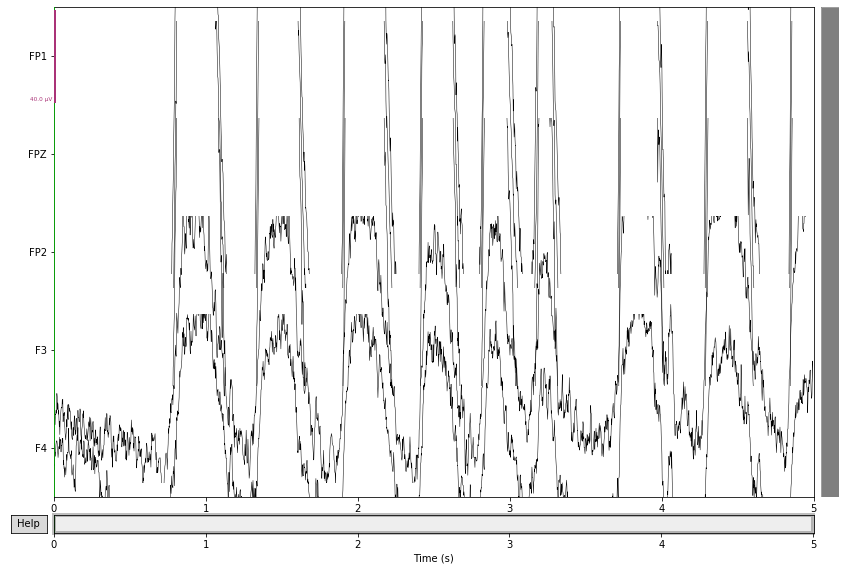

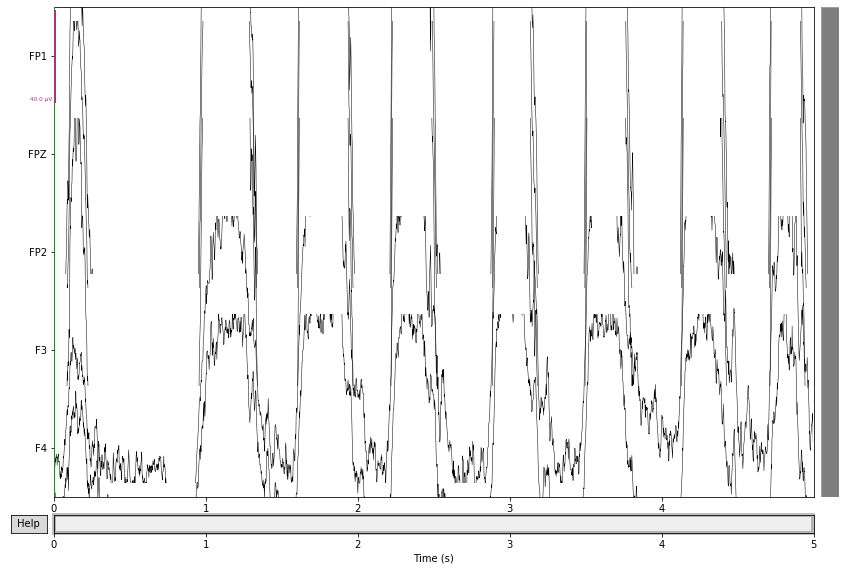

In [3]:
picks = ['FP1', 'FPZ', 'FP2', 'F3', 'F4'] # None / ['eeg'] for first 20 channels or list of channel names for those specified channels

# Since blinking is performed in 2x 5s trials, it's possible the discontinuity at the trial boundary may be falsely marked as an EOG
blinking = [subject.raw_noise['blinking'].copy().crop(tmin=0, tmax=5), subject.raw_noise['blinking'].copy().crop(tmin=5, tmax=None)]
blinking[0].copy().pick(picks).plot();
blinking[1].copy().pick(picks).plot();

Using channel FP1 as EOG channel
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2561 samples (5.002 sec)

Now detecting blinks and generating corresponding events
Found 9 significant peaks
Number of EOG events detected : 9
Using channel FP1 as EOG channel
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
-------------------

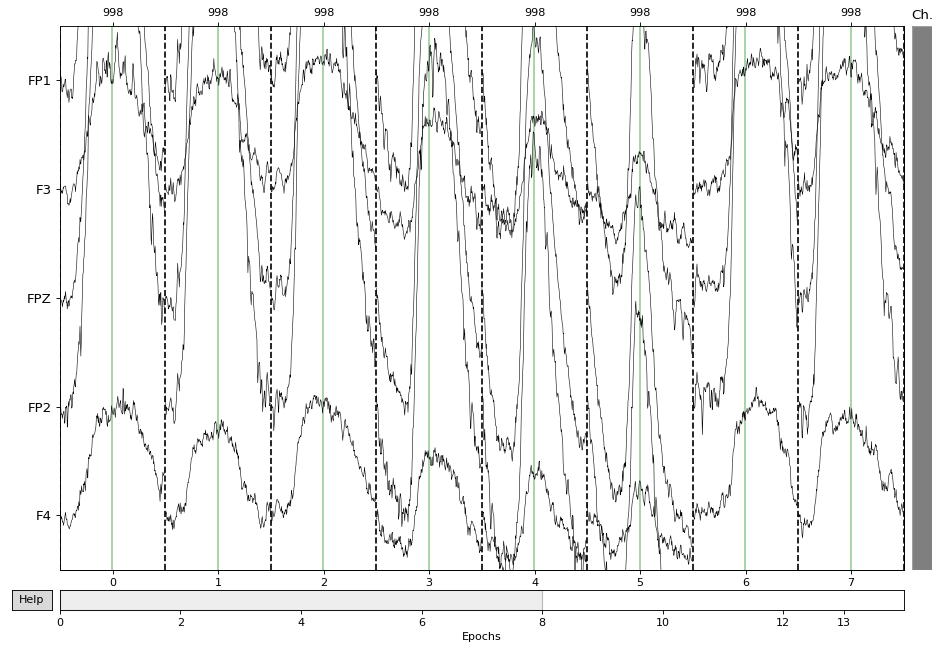

In [6]:
from mne import concatenate_epochs
from mne.preprocessing import find_eog_events
find_eog_ch = 'FP1'
tmin = -0.25
tmax = 0.25
baseline_toffset = 0.01

trial0_blink_events = find_eog_events(blinking[0], ch_name=find_eog_ch, filter_length=2561)    # Match filter length to length of signal
trial1_blink_events = find_eog_events(blinking[1], ch_name=find_eog_ch, filter_length=2560)

trial0_blink_epochs = mne.Epochs(blinking[0], trial0_blink_events, tmin=tmin, tmax=tmax, baseline=(tmin, tmin+baseline_toffset), reject=None, preload=True)
trial1_blink_epochs = mne.Epochs(blinking[1], trial1_blink_events, tmin=tmin, tmax=tmax, baseline=(tmin, tmin+baseline_toffset), reject=None, preload=True)
# trial0_blink_epochs.plot(picks=picks);
# trial1_blink_epochs.plot(picks=picks);

blink_epochs = concatenate_epochs([trial0_blink_epochs, trial1_blink_epochs])
blink_epochs.plot(picks=picks, n_epochs=8);

Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


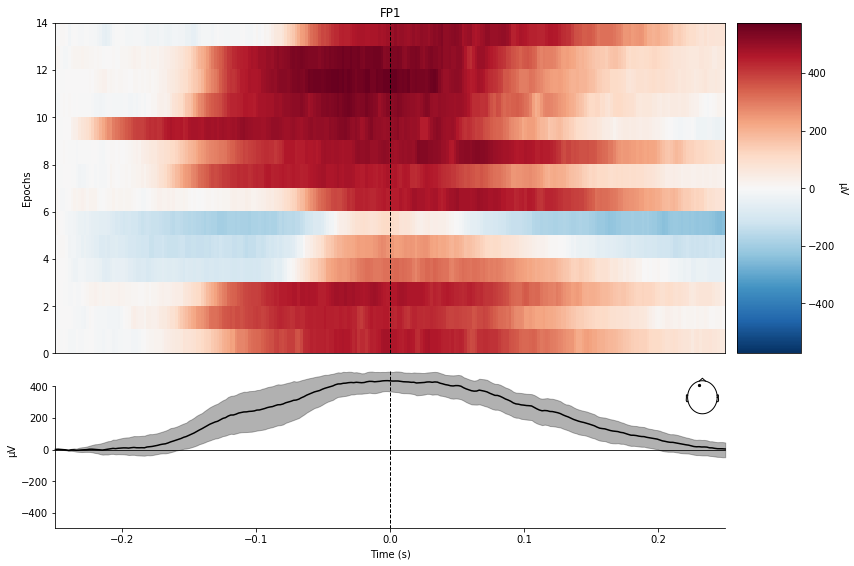

Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


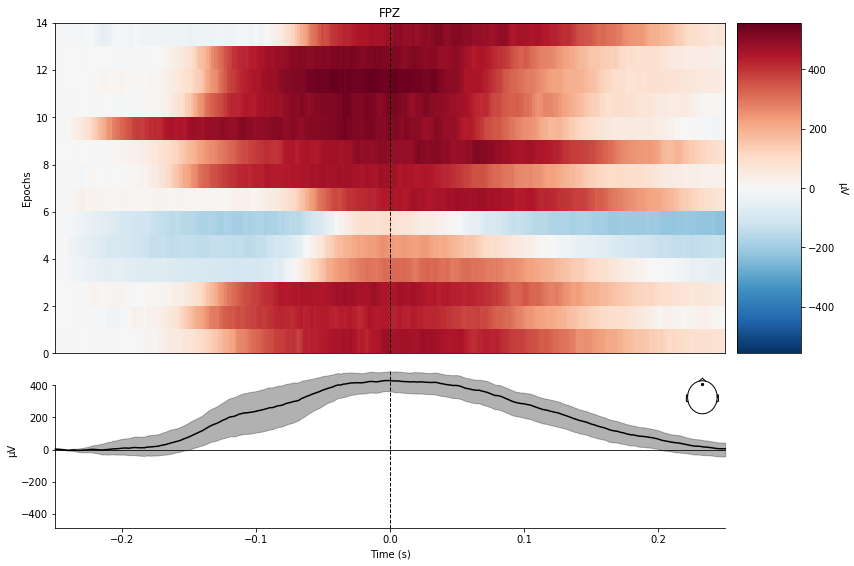

Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


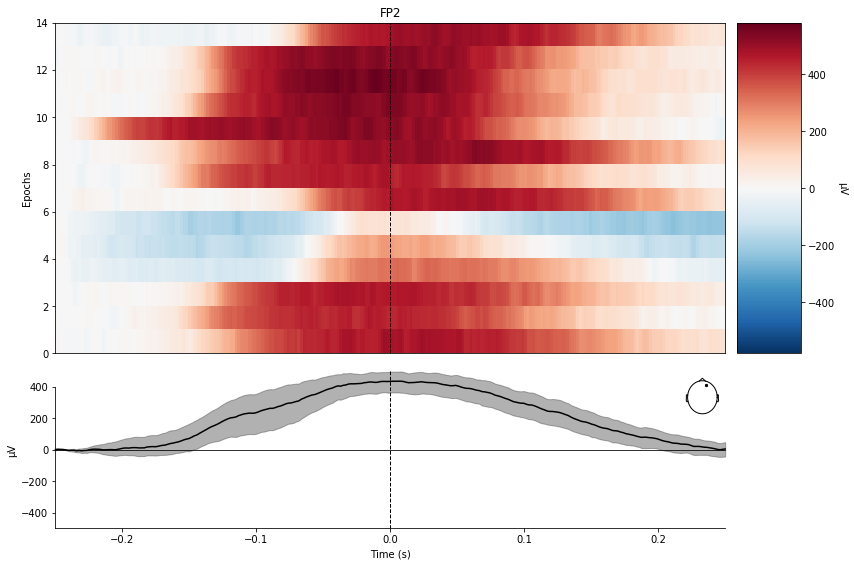

Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


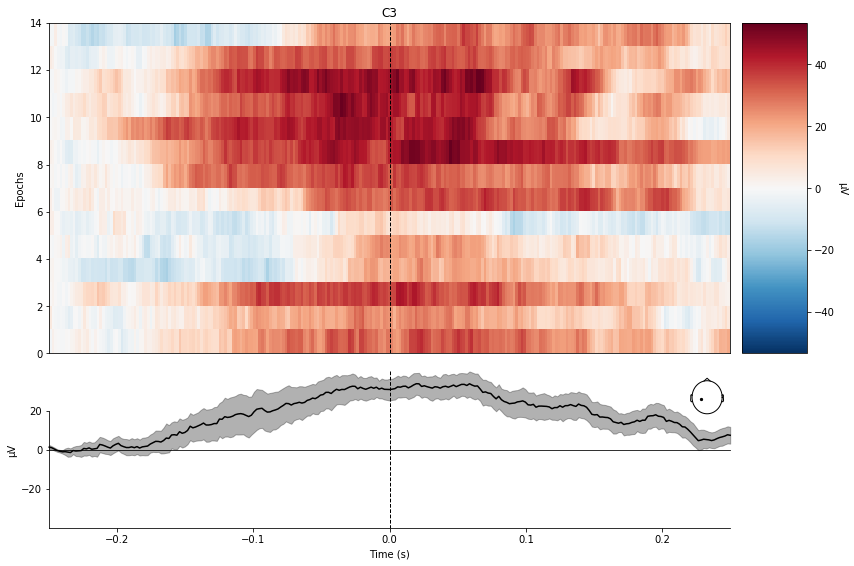

Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


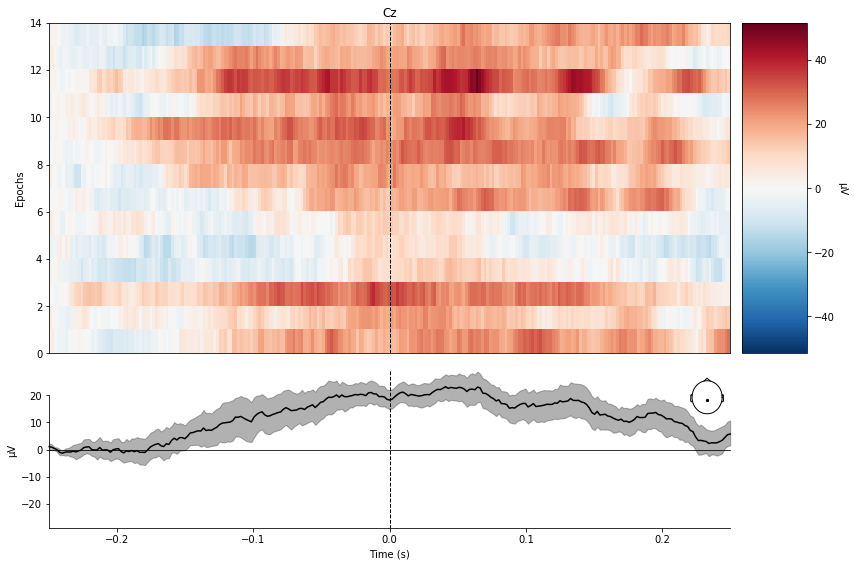

Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


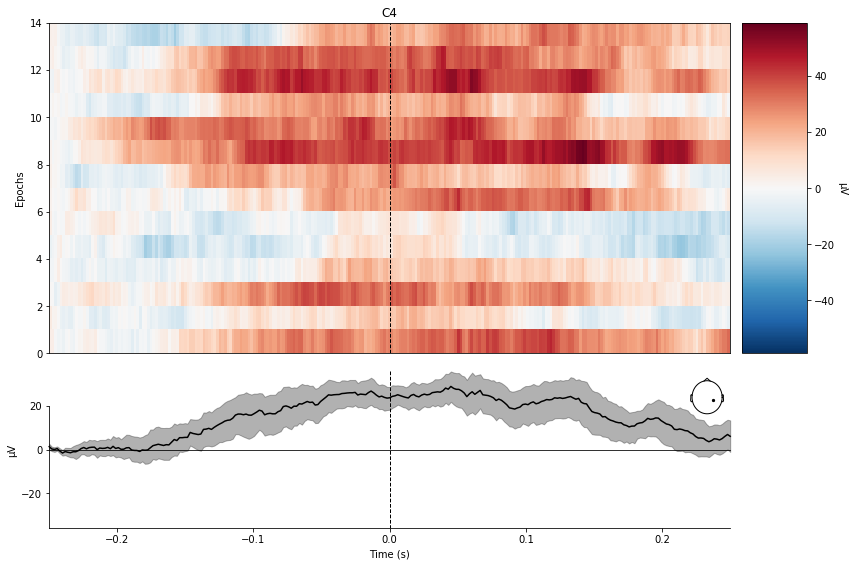

In [18]:
blink_epochs.plot_image(picks='FP1')[0].savefig('/home/justin/Desktop/FP1_image.png');
blink_epochs.plot_image(picks='FPZ')[0].savefig('/home/justin/Desktop/FPZ_image.png');
blink_epochs.plot_image(picks='FP2')[0].savefig('/home/justin/Desktop/FP2_image.png');
blink_epochs.plot_image(picks='C3')[0].savefig('/home/justin/Desktop/C3_image.png');
blink_epochs.plot_image(picks='Cz')[0].savefig('/home/justin/Desktop/Cz_image.png');
blink_epochs.plot_image(picks='C4')[0].savefig('/home/justin/Desktop/C4_image.png');

## Get the average response from blinks

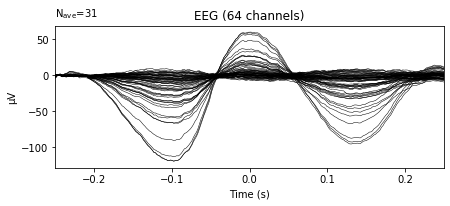

In [6]:
blink_evoked = blink_epochs.average()
blink_evoked.plot();

In [7]:
blink_evoked.info

<Info | 8 non-empty values
 bads: []
 ch_names: FP1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 64 items (64 EEG)
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 512.0 Hz
>

## ICA Feature Extraction of components relating to EOG artifacts

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 64 components
Fitting ICA took 1.0s.


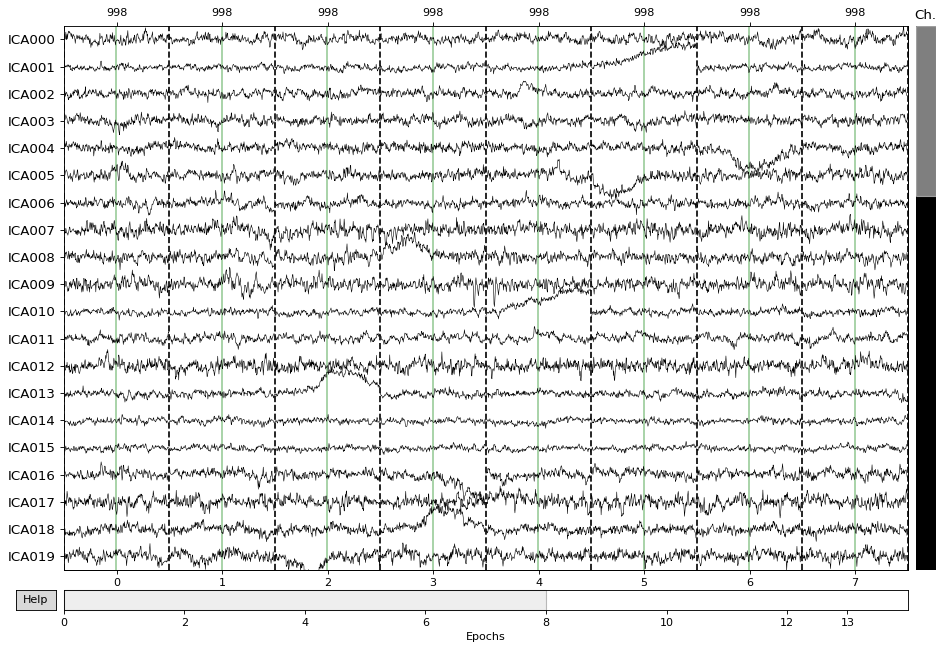

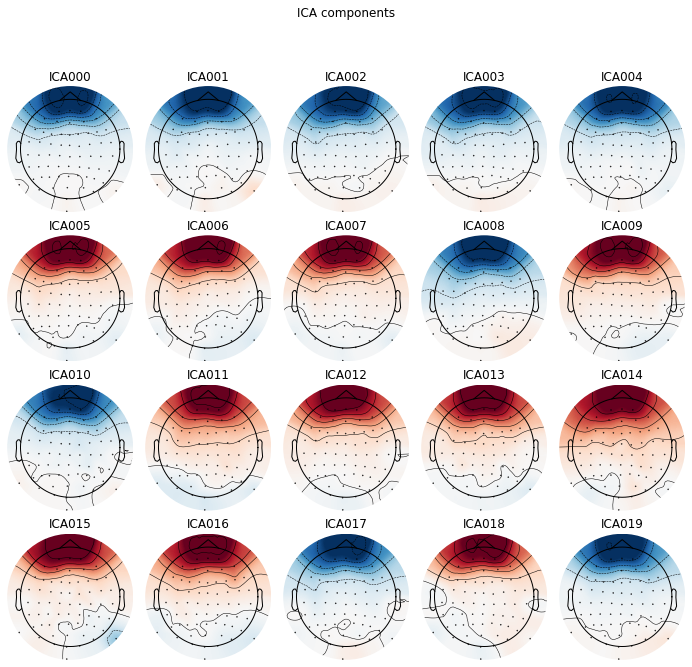

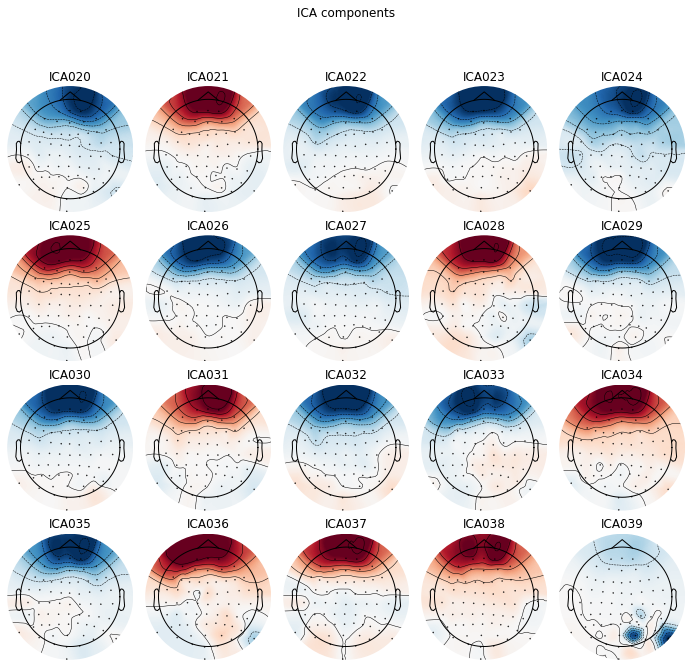

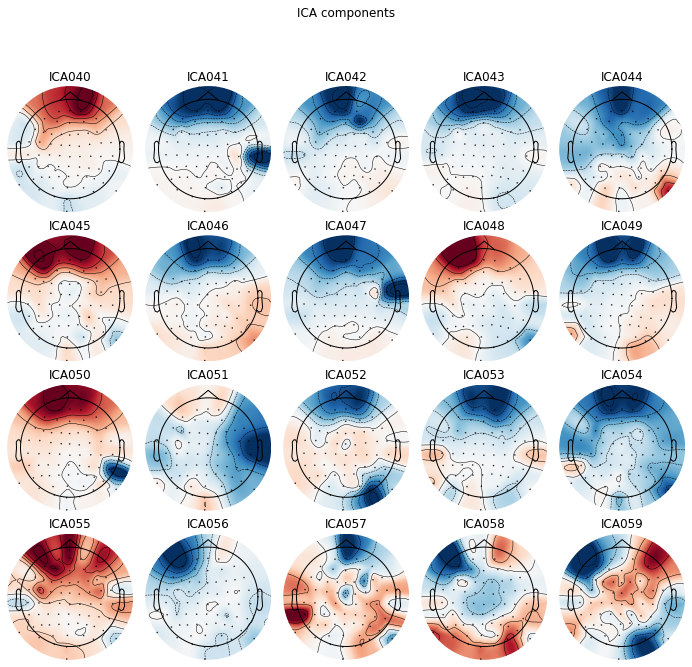

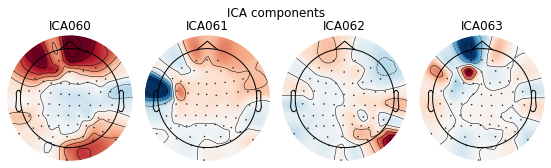

In [20]:
from mne.preprocessing import ICA

n_ica_comps = 64
ica = mne.preprocessing.ICA(n_components=n_ica_comps, random_state=97, max_iter=1000)
ica.fit(blink_epochs)
ica.plot_sources(blink_epochs, stop=8);
ica.plot_components();

In [17]:
ica_excludes = [15, 23, 24, 27, 28, 35, 36, 37, 39, 41, 42, 43 , 45, 46, 48, 50, 51, 54, 55, 56, 57, 58, 59, 60, 61, 63]

ica.exclude = ica_excludes
# ica.plot_properties(blink_epochs, picks='all');

[15, 23, 24, 27, 28, 35, 36, 37, 39, 41, 42, 43, 45, 46, 48, 50, 51, 54, 55, 56, 57, 58, 59, 60, 61, 63]
